# Review Sentiment Analysis

### What we can do :
1. [-1.1]的感情评分进行[1,5]的归一化
2. 评论情感评分的总分布
3. category内的情感评分分布
4. overall和情感分析的correlation关系
5. 与overall进行比较查看是否有虚高（评分和overall的差值）
6. 对虚高进行分析
7. group by each product 进行overall mean和评分mean
8. 对于单一的产品的评分进行虚高分析
9. group by category 以情感评分为指标寻找最受欢迎的子类
10. 使用情感评分作为popular的指标，筛选出最popular和最不popular的top10产品
11. 时间变化的受欢迎程度分析

In [1]:
import warnings; warnings.simplefilter('ignore')

# Math Packages
import math
import pandas as pd
import numpy as n
# Plot Packages 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#NLP libraries
import spacy

In [2]:
DATA_FOLDER = "./data/"
META_HEALTH_CARE = "health_metadata.pkl"
REVIEWS_HEALTH_CARE = "health_review.pkl"
HEALTH_CARE = "health_merge.pkl"
PRODUCT_REVIEW_INFO = "product_review_info.pkl"

## Sentiment Analysis and Normalization

In [31]:
# Read product information in Health care including reviews
df_health_care = pd.read_pickle(DATA_FOLDER+ HEALTH_CARE)

df_product_review = df_health_care[["asin","title","reviewText","ReviewTime","categories","overall"]]

analyzer = SentimentIntensityAnalyzer()
df_product_review['reviewScore'] = df_product_review['reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_product_review['reviewScoreNorm'] = df_product_review[['reviewScore']] * 2 + 3

df_product_review.head()

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm
0,0077614992,Principles of Mgmt + Oper-CSUF Custom C,This book was a requirement for a college clas...,2013-02-15,[[Health & Personal Care]],0.2263,5,3.4526
1,0615208479,Brain Fitness Exercises Software,This is a great gift for anyone who wants to h...,2008-12-01,"[[Health & Personal Care, Personal Care]]",0.9748,5,4.9496
2,0615269990,Occam's Razor,Very helpful in learning about different disea...,2014-04-06,"[[Health & Personal Care, Personal Care, Shavi...",0.8313,5,4.6626
3,0615269990,Occam's Razor,Occam's Razor is an unbelievably intuitive and...,2013-12-04,"[[Health & Personal Care, Personal Care, Shavi...",0.9984,5,4.9968
4,0615269990,Occam's Razor,I met the guys from Nerdcore at a medical conf...,2014-04-24,"[[Health & Personal Care, Personal Care, Shavi...",0.4664,2,3.9328


In [32]:
# save as pickle
df_product_review.to_pickle(DATA_FOLDER + PRODUCT_REVIEW_INFO)

## Sentiment Distribution Analysis

### Total

In [3]:
# read from pickle
df_product_review = pd.read_pickle(DATA_FOLDER + PRODUCT_REVIEW_INFO)

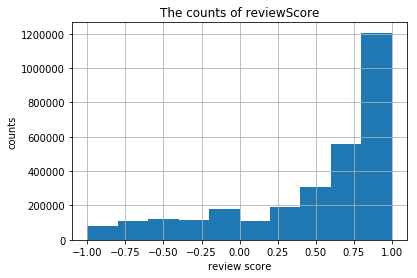

In [49]:
# plot distribution
df_product_review["reviewScore"].hist(bins=10)
plt.xlabel("review score")
plt.ylabel("counts")
plt.title("The counts of reviewScore")
plt.show()

In [9]:
pos_num = len(df_product_review[df_product_review["reviewScore"]>=0.05])
neu_num = len(df_product_review[(df_product_review["reviewScore"]>-0.05) & (df_product_review["reviewScore"]<0.05)])
neg_num = len(df_product_review[df_product_review["reviewScore"]<=-0.05])
total_num = len(df_product_review)

print("The number of positive reviews is :{pn} and occupies {p:.3f}% in the review".format(pn=pos_num,p=pos_num*100/total_num))
print("The number of neutral reviews is :{nu} and occupies {p:.3f}% in the review".format(nu=neu_num,p=neu_num*100/total_num))
print("The number of negative reviews is :{nu}and occupies {p:.3f}% in the review".format(nu=neg_num,p=neg_num*100/total_num))

The number of positive reviews is :2353432 and occupies 79.155% in the review
The number of neutral reviews is :124861 and occupies 4.200% in the review
The number of negative reviews is :494893and occupies 16.645% in the review


In [4]:
df_product_review.loc[df_product_review["reviewScore"]>=0.05,"label"]="positive"
df_product_review.loc[(df_product_review["reviewScore"]>-0.05) & (df_product_review["reviewScore"]<0.05),"label"]="neutral"
df_product_review.loc[df_product_review["reviewScore"]<=-0.05,"label"]="negative"

In [53]:
df_product_review.head()

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm,label
0,0077614992,Principles of Mgmt + Oper-CSUF Custom C,This book was a requirement for a college clas...,2013-02-15,[[Health & Personal Care]],0.2263,5,3.4526,positive
1,0615208479,Brain Fitness Exercises Software,This is a great gift for anyone who wants to h...,2008-12-01,"[[Health & Personal Care, Personal Care]]",0.9748,5,4.9496,positive
2,0615269990,Occam's Razor,Very helpful in learning about different disea...,2014-04-06,"[[Health & Personal Care, Personal Care, Shavi...",0.8313,5,4.6626,positive
3,0615269990,Occam's Razor,Occam's Razor is an unbelievably intuitive and...,2013-12-04,"[[Health & Personal Care, Personal Care, Shavi...",0.9984,5,4.9968,positive
4,0615269990,Occam's Razor,I met the guys from Nerdcore at a medical conf...,2014-04-24,"[[Health & Personal Care, Personal Care, Shavi...",0.4664,2,3.9328,positive


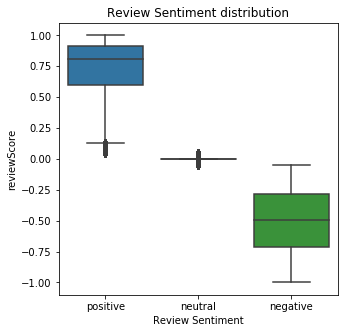

In [57]:
plt.figure(figsize=(5,5))
sns.boxplot(x="label", y="reviewScore", data=df_product_review,order=["positive", "neutral","negative"])
plt.xlabel("Review Sentiment")
plt.title("Review Sentiment distribution")
plt.show()

In [60]:
df_product_review[["reviewScore"]].describe()

,reviewScore
count,2.973186e+06
mean,4.938181e-01
std,5.216410e-01
min,-9.999000e-01
25%,2.382000e-01
50%,7.156000e-01
75%,8.910000e-01
max,1.000000e+00


In [62]:
df_product_review.loc[df_product_review["reviewScore"]>=0.05,"reviewScore"].describe()

count    2.353432e+06
mean     7.287716e-01
std      2.335450e-01
min      5.000000e-02
25%      5.994000e-01
50%      8.070000e-01
75%      9.141000e-01
max      1.000000e+00
Name: reviewScore, dtype: float64

In [63]:
df_product_review.loc[(df_product_review["reviewScore"]>-0.05) & (df_product_review["reviewScore"]<0.05),"reviewScore"].describe()

count    124861.000000
mean          0.000436
std           0.015195
min          -0.049900
25%           0.000000
50%           0.000000
75%           0.000000
max           0.049900
Name: reviewScore, dtype: float64

In [64]:
df_product_review.loc[df_product_review["reviewScore"]<=-0.05,"reviewScore"].describe()

count    494893.000000
mean         -0.499008
std           0.256299
min          -0.999900
25%          -0.713000
50%          -0.493900
75%          -0.286900
max          -0.050000
Name: reviewScore, dtype: float64

### Sub-categories

difference analysis

In [59]:
df_product_cat_review = df_product_review.copy()

def find_subcat(x):
    if(len(x[0])==1):
        return 'default'
    else:
        return x[0][1]

df_product_cat_review["subcategories"] = df_product_cat_review["categories"].apply(lambda x:find_subcat(x))
df_product_cat_review = df_product_cat_review[["subcategories","reviewScore","overall","reviewScoreNorm"]]
df_product_cat_review.head()

,subcategories,reviewScore,overall,reviewScoreNorm
0,default,0.2263,5,3.4526
1,Personal Care,0.9748,5,4.9496
2,Personal Care,0.8313,5,4.6626
3,Personal Care,0.9984,5,4.9968
4,Personal Care,0.4664,2,3.9328


In [61]:
df_product_cat_group = df_product_cat_review.groupby('subcategories').mean().sort_values('reviewScore',ascending = False)
df_product_cat_group

,reviewScore,overall,reviewScoreNorm
subcategories,,,
Baby & Child Care,0.609269,4.205483,4.218539
Stationery & Party Supplies,0.602765,4.102568,4.205530
Sports Nutrition,0.589311,4.237650,4.178623
Personal Care,0.519627,4.102509,4.039254
Household Supplies,0.518710,4.192494,4.037421
default,0.490678,4.019077,3.981356
Sexual Wellness,0.486434,3.694860,3.972868
Medical Supplies & Equipment,0.485439,4.071935,3.970878
Health Care,0.458111,4.127009,3.916223


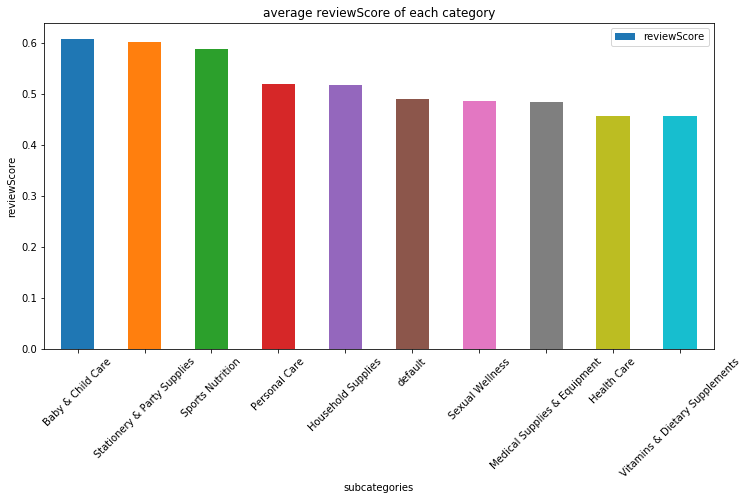

In [99]:
df_product_cat_group.plot.bar(y='reviewScore', rot=45,figsize=(12,6))
plt.ylabel("reviewScore")
plt.title("average reviewScore of each category")
plt.show()

In [62]:
df_product_cat_group["Diff"] = df_product_cat_group["reviewScoreNorm"] - df_product_cat_group["overall"]
df_product_cat_group

,reviewScore,overall,reviewScoreNorm,Diff
subcategories,,,,
Baby & Child Care,0.609269,4.205483,4.218539,0.013055
Stationery & Party Supplies,0.602765,4.102568,4.205530,0.102962
Sports Nutrition,0.589311,4.237650,4.178623,-0.059027
Personal Care,0.519627,4.102509,4.039254,-0.063255
Household Supplies,0.518710,4.192494,4.037421,-0.155073
default,0.490678,4.019077,3.981356,-0.037721
Sexual Wellness,0.486434,3.694860,3.972868,0.278008
Medical Supplies & Equipment,0.485439,4.071935,3.970878,-0.101057
Health Care,0.458111,4.127009,3.916223,-0.210786


In [ ]:
df_cat_diff = df_product_cat_group.loc[:,["overall","reviewScoreNorm"]]
df_cat_diff = df_cat_diff.stack()
df_cat_diff = df_cat_diff.to_frame()
df_cat_diff.reset_index(inplace=True)
df_cat_diff.columns = df_cat_diff.columns.astype(str)
df_cat_diff.rename(columns={"level_1":"scoretype","0":"score"},inplace=True)

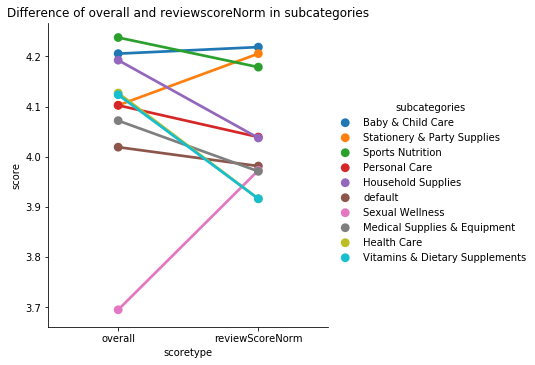

In [127]:
sns.catplot(x="scoretype", y="score",hue="subcategories", kind="point", data=df_cat_diff)
plt.title("Difference of overall and reviewscoreNorm in subcategories")
plt.show()

Absolute difference analysis

In [82]:
df_product_cat_group["absDiff"] = abs(df_product_cat_group["Diff"])

In [95]:
df_product_cat_group.sort_values("absDiff")

,reviewScore,overall,reviewScoreNorm,Diff,absDiff
subcategories,,,,,
Baby & Child Care,0.609269,4.205483,4.218539,0.013055,0.013055
default,0.490678,4.019077,3.981356,-0.037721,0.037721
Sports Nutrition,0.589311,4.237650,4.178623,-0.059027,0.059027
Personal Care,0.519627,4.102509,4.039254,-0.063255,0.063255
Medical Supplies & Equipment,0.485439,4.071935,3.970878,-0.101057,0.101057
Stationery & Party Supplies,0.602765,4.102568,4.205530,0.102962,0.102962
Household Supplies,0.518710,4.192494,4.037421,-0.155073,0.155073
Vitamins & Dietary Supplements,0.458098,4.123549,3.916197,-0.207352,0.207352
Health Care,0.458111,4.127009,3.916223,-0.210786,0.210786


## Rating VS ReviewScore

Difference Analysis

In [63]:
df_product_review["Diff"] = df_product_review["reviewScoreNorm"] - df_product_review["overall"]
df_product_review.head()

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm,label,Diff
0,0077614992,Principles of Mgmt + Oper-CSUF Custom C,This book was a requirement for a college clas...,2013-02-15,[[Health & Personal Care]],0.2263,5,3.4526,positive,-1.5474
1,0615208479,Brain Fitness Exercises Software,This is a great gift for anyone who wants to h...,2008-12-01,"[[Health & Personal Care, Personal Care]]",0.9748,5,4.9496,positive,-0.0504
2,0615269990,Occam's Razor,Very helpful in learning about different disea...,2014-04-06,"[[Health & Personal Care, Personal Care, Shavi...",0.8313,5,4.6626,positive,-0.3374
3,0615269990,Occam's Razor,Occam's Razor is an unbelievably intuitive and...,2013-12-04,"[[Health & Personal Care, Personal Care, Shavi...",0.9984,5,4.9968,positive,-0.0032
4,0615269990,Occam's Razor,I met the guys from Nerdcore at a medical conf...,2014-04-24,"[[Health & Personal Care, Personal Care, Shavi...",0.4664,2,3.9328,positive,1.9328


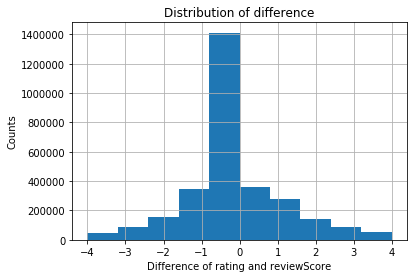

In [64]:
df_product_review["Diff"].hist(bins=10)
plt.xlabel("Difference of rating and reviewScore")
plt.ylabel("Counts")
plt.title("Distribution of difference")
plt.show()

In [72]:
# set threshold representing that the reviewScore is consistent with the rating, otherwise it's not.
# and the number of inconsistence and consistence
threshold = 1.0
diff_g1 = len(df_product_review[(df_product_review["Diff"]>threshold) | (df_product_review["Diff"]<(-1)*threshold)])
diff_s1 = len(df_product_review[(df_product_review["Diff"]<=threshold) & (df_product_review["Diff"]>=(-1)*threshold)])

print("The number of consistent rating with difference which is not greater than one is {s1}, and occupies {p:.3f}% in reviews"\
                                                          .format(s1=diff_s1,p=diff_s1*100/total_num))
print("The number of inconsistent rating with difference which is greater than one is {g1}, and occupies {p:.3f}% in reviews"\
                                                          .format(g1=diff_g1,p=diff_g1*100/total_num))

The number of consistent rating with difference which is not greater than one is 2053019, and occupies 69.051% in reviews
The number of inconsistent rating with difference which is greater than one is 920167, and occupies 30.949% in reviews


In [77]:
df_diff_g1 = df_product_review[(df_product_review["Diff"]>threshold) | (df_product_review["Diff"]<(-1)*threshold)]

In [79]:
df_diff_g1["absDiff"] = abs(df_diff_g1["Diff"])
df_diff_g1["absDiff"].describe()

count    920167.000000
mean          2.032174
std           0.792226
min           1.000200
25%           1.363600
50%           1.873400
75%           2.592000
max           4.000000
Name: absDiff, dtype: float64